## Análise das partidas de um jogador na plataforma Chess.com


Neste projeto buscamos fazer uma análise exploratória dos dados de todas as partidas de um jogador arbitrário (eu) na plataforma Chess.com com o objetivo de responder às seguintes questões: 

1. O jogador joga melhor de Pretas, de Brancas, ou isso depende de algum outro fator?
2. Quais as relações entre o rating (pontuação) de um oponente e o resultado da partida? Por exemplo, será que necessariamente o jogador tende a empatar com jogadores de rating mais próximo ao seu?

O Pojeto está dividido nas seguintes partes: 
- Extração e transformação dos dados;
- Respostas às perguntas supracitadas

#### Importação:

Iniciamos importando os módulos, bibliotecas e funções usados:

In [1]:
import concurrent.futures
from datetime import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import transform.chess_transform as ct
from extract.chess_request import request_games
from extract.chess_request import get_user
from plotting import double_pie_chart

### <u>Extração e Transformação de Dados</u>

Os dados serão extraídos da API do Chess.com. A API tem as partidas de cada mês em endpoints separados. Para pegar todas as partidas de Julho de 2018 para o dia de hoje, devemos fazer várias requisições à API, e isso pode custar tempo. Para acelerar este processo, criamos a função abaixo para fazer requisições de maneira concorrente:

In [2]:
def worker(year_,user_,email_):
	df_list = []
	current_month = datetime.now().month
	global current_year

	for month in range(1, 13):
		df = request_games(year_, month, user_, email_)
		df_list += [df]
		if (year_ == current_year) and (month == current_month):
			break
	return pd.concat(df_list)

Abaixo extraímos os dados:

In [3]:
user = "morpha_21" # Grande mestre
current_year = datetime.now().year

# preenchendo a variável email com o conteúdo de um arquivo oculto
with open("extract/.email", 'r') as email_file:
	email = email_file.read().strip()

# fazendo requisições em filas concorrentes (uma para cada ano)
with concurrent.futures.ThreadPoolExecutor() as executor:
	futures = []
	for year in range(2020, current_year+1):
			futures += [executor.submit(worker, year, user, email)]
	df_list = [f.result() for f in futures]

df = pd.concat(df_list)    

requesting game data from 12/2022...   

Abaixo aplicamos algumas transformações, salvamos o DataFrame em um arquivo CSV para uso futuro e, finalmente, exibimos nosso conjunto de dados:

In [4]:
df = ct.adequate(df)
df.sort_index(inplace=True)
df   = ct.personalize(df, user)

df.to_csv(f"{user}.csv")

Uma vez coletados os dados, podemos importá-los assim:

In [8]:
df = pd.read_csv('morpha_21.csv', index_col='end_time')
df.index = pd.to_datetime(df.index)
df

,time_control,time_class,rating,played_as,result,against,opponent_rating,opponent,opponent_result,opponent_uuid,rated,url,draw
end_time,,,,,,,,,,,,,
2020-11-12 20:36:32,600,rapid,593,white,win,black,380,flop2198,checkmated,d426f50c-23cf-11eb-a305-650bf49edb6f,True,https://www.chess.com/game/live/5734518923,False
2020-11-12 20:54:45,600,rapid,721,white,win,black,517,MidoruHamu,abandoned,06e663e6-253e-11eb-a576-658bc1b921ad,True,https://www.chess.com/game/live/5734560806,False
2020-11-12 21:10:06,600,rapid,800,black,win,white,617,andrew634118,checkmated,6d98ebb8-23ef-11eb-9f0f-db0d49e8b7b7,True,https://www.chess.com/game/live/5734634805,False
2020-11-12 21:29:39,600,rapid,736,black,checkmated,white,973,moubenabd,win,a3f1cbf2-2544-11eb-8e5a-432d14cd12fc,True,https://www.chess.com/game/live/5734693761,False
2020-11-12 21:50:12,600,rapid,679,white,timeout,black,833,zeebeezkneez,win,cb2ed5de-2490-11eb-926f-0520c8ac5516,True,https://www.chess.com/game/live/5734763421,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-25 11:45:35,300,blitz,1041,black,checkmated,white,1013,Naaf2789,win,5076c764-971f-11eb-95f7-39365da62869,True,https://www.chess.com/game/live/102610953875,False
2024-02-25 11:55:16,300,blitz,1032,black,checkmated,white,1024,Sicilianbuddy,win,5b9205f0-b29f-11eb-a600-3bc3c181662d,True,https://www.chess.com/game/live/102611432597,False
2024-02-25 12:02:13,300,blitz,1025,white,checkmated,black,1073,Aaronfrancis07,win,98829638-71e4-11eb-aa75-b704ea7bdcf7,True,https://www.chess.com/game/live/102612019411,False


Vamos começar entendendo as colunas de que dispomos: 
- `'time_control'`: quantidade de segundos disponíveis no relógio de cada jogador no início da partida. Pode ser um número apenas, como 180 (indicando partidas de 3 minutos), ou algo como "60+1", que indica que cada jogador tem 1 minuto no relógio e ganha mais 1 segundo a cada lance.
- `'time_class'`: Categoria do jogo, classificado a partir do tempo de duração da partida. 
- `'rating'` e `'opponent_rating`': Pontuação do jogador, naquela categoria, ao final da partida. Jogadores tem ratings diferentes para categorias (valores de 'time_class') distintas.
- `'played_as'` e `'against'`: Cores das peças do Jogador e de seu oponente, respectivamente. 
- `'opponent'` e `'opponent_uuid'`: Nome de usuário e uuid do oponente, respectivamente.
- `'result'` e `'opponent_result'`: resultado da partida para cada jogador. "Win" indica que o jogador ou o oponente (a depender da coluna em que se encontra) venceu a partida. Em caso de derrota ou empate, a coluna consta com o valor que representa do motivo do empate.
- `'rated'`: indica se a partida estava valendo pontos.
- `url`: url da partida, onde pode se observar todos os seus lances.
- `'draw'`: indica se a partida terminou ou não em empate.

Abaixo, podemos ver o controle de tempo das partidas que o jogador disputou em cada categoria.

In [9]:
for category in df['time_class'].unique():
    print(category+":\t",df[df['time_class'] == category]['time_control'].unique())

rapid:	 ['600' '900+10' '1800']
blitz:	 ['300' '180' '300+5' '180+2']
bullet:	 ['60' '120+1' '60+1']


Vamos agora definir filtros que facilitarão nossa análise:

In [10]:
blitz = (df['time_class'] == 'blitz')
bullet = (df['time_class'] == 'bullet')
rapid = (df['time_class'] == 'rapid')

for category in [(blitz,"blitz"), (bullet,"bullet"), (rapid,"rapid")]:
    print(f"Quantidade de jogos em {category[1]}:\t{category[0].sum()}")

Quantidade de jogos em blitz:	5506
Quantidade de jogos em bullet:	1772
Quantidade de jogos em rapid:	2666


## 1. Joga melhor de Brancas ou Pretas?

De modo geral, considera-se que é melhor jogar de Brancas do que de Pretas porque as brancas iniciam uma partida. Mas veremos se os dados corroboram com essa hipótese no caso de nosso jogador. Para responder a essa pergunta, começamos olhando para o total de vitórias, empates e derrotas com cada cor: 

Vitórias de pretas:	2371/4971 (47.7%)
Empates de pretas:	114/4971 (2.29%)
Derrotas de pretas:	2486/4971 (50.01%)

Vitórias de brancas:	2563/4973 (51.54%)
Empates de brancas:	148/4973 (2.98%)
Derrotas de brancas:	2262/4973 (45.49%)


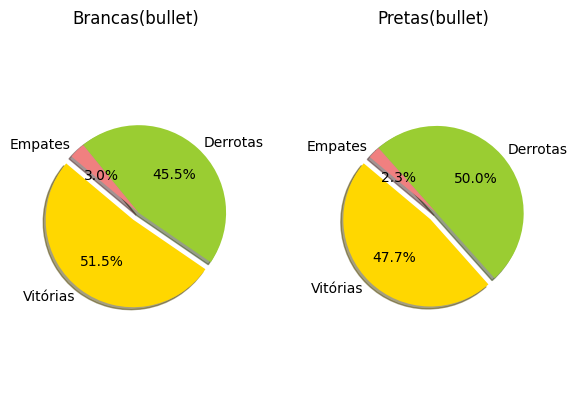

In [16]:
black_total = df[df.played_as == 'black'].shape[0]
black_win = df[(df.played_as == 'black') & (df.result == 'win')].shape[0]
black_lost = df[(df.played_as == 'black') & (df.draw == False) & (df.result != 'win')].shape[0]
black_draw = df[(df.played_as == 'black') & (df.draw)].shape[0]

white_total = df[df.played_as == 'white'].shape[0]
white_win = df[(df.played_as == 'white') & (df.result == 'win')].shape[0]
white_lost = df[(df.played_as == 'white') & (df.draw == False) & (df.result != 'win')].shape[0]
white_draw = df[(df.played_as == 'white') & (df.draw)].shape[0]

print(f"Vitórias de pretas:\t{black_win}/{black_total} ({np.round(100*black_win/black_total, 2)}%)")
print(f"Empates de pretas:\t{black_draw}/{black_total} ({np.round(100*black_draw/black_total, 2)}%)")
print(f"Derrotas de pretas:\t{black_lost}/{black_total} ({np.round(100*black_lost/black_total, 2)}%)")
print()
print(f"Vitórias de brancas:\t{white_win}/{white_total} ({np.round(100*white_win/white_total, 2)}%)")
print(f"Empates de brancas:\t{white_draw}/{white_total} ({np.round(100*white_draw/white_total, 2)}%)")
print(f"Derrotas de brancas:\t{white_lost}/{white_total} ({np.round(100*white_lost/white_total, 2)}%)")

brancas = [white_win, white_lost, white_draw]
pretas = [black_win, black_lost, black_draw]    

double_pie_chart([brancas, pretas], labels, [f'Brancas({category})', f'Pretas({category})'])


Vemos que, aparentemente, o jogador tem um desempenho ligeiramente melhor em partidas disputadas com as peças brancas: Ele sofre menos derrotas, e também costuma ganhar mais vezes. Vamos agora ver como esses números ficam segmentados para as diferentes categorias de tempo: Rapid, Blitz e Bullet: 

rapid:
	Vitórias de brancas:	669/1328 (50.4%)
	Derrotas de brancas:	615/1328 (46.3%)
	Empates de brancas:	44/1328  (3.3%)

	Vitórias de pretas:	653/1338 (48.8%)
	Derrotas de pretas:	639/1338 (47.8%)
	Empates de pretas:	46/1338   (3.4%)



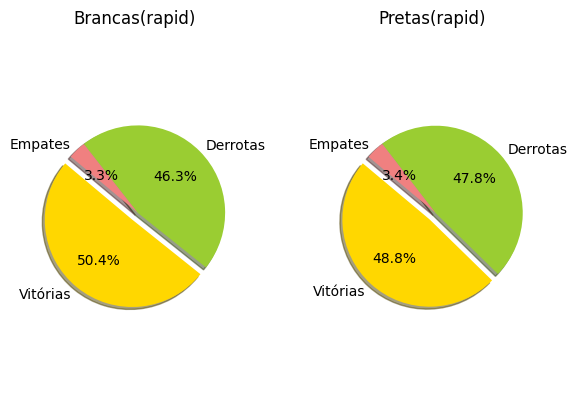

blitz:
	Vitórias de brancas:	1429/2748 (52.0%)
	Derrotas de brancas:	1237/2748 (45.0%)
	Empates de brancas:	82/2748  (3.0%)

	Vitórias de pretas:	1291/2758 (46.8%)
	Derrotas de pretas:	1406/2758 (51.0%)
	Empates de pretas:	61/2758   (2.2%)



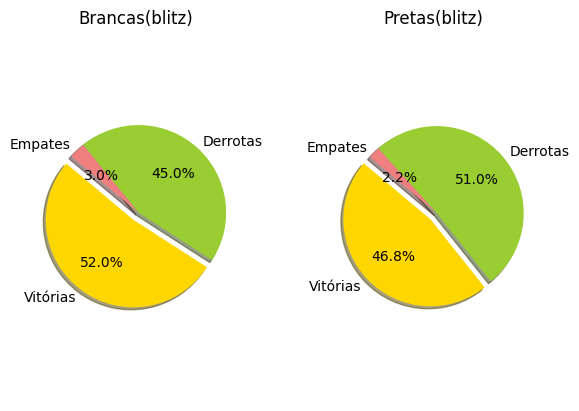

bullet:
	Vitórias de brancas:	465/897 (51.8%)
	Derrotas de brancas:	410/897 (45.7%)
	Empates de brancas:	22/897  (2.5%)

	Vitórias de pretas:	427/875 (48.8%)
	Derrotas de pretas:	441/875 (50.4%)
	Empates de pretas:	7/875   (0.8%)



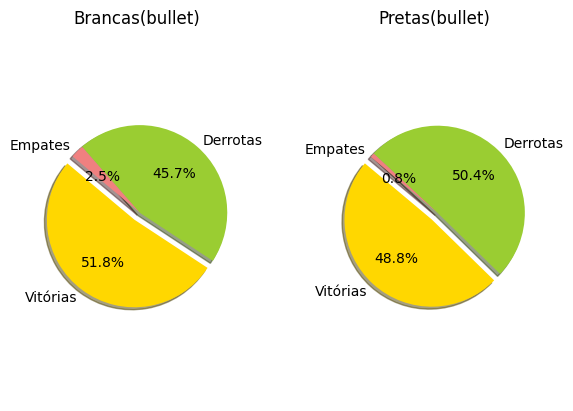

In [15]:
for category in df.time_class.unique():
    print(category+":")
    black_total = df[(df.played_as == 'black') & (df.time_class == category)].shape[0]
    black_win = df[(df.played_as == 'black') & (df.result == 'win')& (df.time_class == category)].shape[0]
    black_lost = df[(df.played_as == 'black') & (df.draw == False) & (df.result != 'win')& (df.time_class == category)].shape[0]
    black_draw = df[(df.played_as == 'black') & (df.draw)& (df.time_class == category)].shape[0]

    white_total = df[(df.played_as == 'white') & (df.time_class == category)& (df.time_class == category)].shape[0]
    white_win = df[(df.played_as == 'white') & (df.result == 'win')& (df.time_class == category)].shape[0]
    white_lost = df[(df.played_as == 'white') & (df.draw == False) & (df.result != 'win')& (df.time_class == category)].shape[0]
    white_draw = df[(df.played_as == 'white') & (df.draw)& (df.time_class == category)].shape[0]

    print(f"\tVitórias de brancas:\t{white_win}/{white_total} ({np.round(100*white_win/white_total, 1)}%)")
    print(f"\tDerrotas de brancas:\t{white_lost}/{white_total} ({np.round(100*white_lost/white_total, 1)}%)")
    print(f"\tEmpates de brancas:\t{white_draw}/{white_total}  ({np.round(100*white_draw/white_total, 1)}%)")
    print()
    print(f"\tVitórias de pretas:\t{black_win}/{black_total} ({np.round(100*black_win/black_total, 1)}%)")
    print(f"\tDerrotas de pretas:\t{black_lost}/{black_total} ({np.round(100*black_lost/black_total, 1)}%)")
    print(f"\tEmpates de pretas:\t{black_draw}/{black_total}   ({np.round(100*black_draw/black_total, 1)}%)")
    print()

    brancas = [white_win, white_lost, white_draw]
    pretas = [black_win, black_lost, black_draw]    

    double_pie_chart([brancas, pretas], labels, [f'Brancas({category})', f'Pretas({category})'])